In [1]:
from __future__ import unicode_literals, print_function, division

import glob
import os
import random
import time
import math
import torch
import torchvision
import unicodedata
import string

import pandas as pd
import torch.nn as nn
import torchvision.transforms as transforms

from io import open
from matplotlib import pyplot as plt
from collections import defaultdict
from sklearn.model_selection import train_test_split

# Set Up

In [2]:
# Build the language_words dictionary, a list of words per language
def parseCSV(file):
    """returns pandas dataframe from CSV file"""
    data = pd.read_csv(file)
    return data

def reformatData(data):
    """takes in pandas dataframe and outputs data in right format"""
    language_words = defaultdict(list) 
    data = data.to_dict('split')['data']
    
    for entry in data:
        language_words[entry[1]].append(entry[0])
        
    return dict(language_words)

Parse our language dataset and populate four variables we will be using later:

training_words = `{'Simlish': ['Dag Dag', 'Zagadoo', ...], 'English': ['event', ...], ...}`

test_words = same format at training_words

all_languages = `['English', 'Spanish', 'Tolkien Elvish', ...]`

n_languages = 7

In [3]:
# parse the data for characters we need to include
csv_data = parseCSV('language_dataset.csv')
csv_data["Word"]= csv_data["Word"].str.lower()
language_words = reformatData(csv_data)

# populate all_letters with alphabet lower and upper 
# along with spaces and a few other punctuations
all_letters = set()

for letter in 'abcdefghijklmnopqrstuvwxyz' + " .,;'" + 'áéíóúüñàèìòùçâêîôûëïäöß()-āēīōū’ā̆ē̆ī̆ō̆ăĭḗū́u̯ṇ̃þʒ¹²/':
    all_letters.add(letter)

# we also need to include special characters found in certain languages
# primarily Tolkien Elvish and Spanish
for lang in language_words.keys():
    for word in language_words[lang]:
        for letter in word:
            all_letters.add(letter)      
            
n_letters = len(all_letters)
all_letters = sorted(list(all_letters))
print('n_letters:', n_letters)
print('all_letters:', all_letters)

n_letters: 82
all_letters: [' ', "'", '(', ')', ',', '-', '.', '/', ';', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '²', '¹', 'ß', 'à', 'á', 'â', 'ä', 'ç', 'è', 'é', 'ê', 'ë', 'ì', 'í', 'î', 'ï', 'ñ', 'ò', 'ó', 'ô', 'ö', 'ù', 'ú', 'û', 'ü', 'þ', 'ā', 'ă', 'ē', 'ĕ', 'ī', 'ĭ', 'ō', 'ŏ', 'œ', 'ū', 'ƀ', 'ʒ', 'ˢ', '́', '̆', '̣', '̯', 'ṃ', 'ṇ', '’', '…']


In [4]:
# Turn names into tensors
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    try:
        if letter == '\xa0':
            letter = ' '
        return all_letters.index(letter)
    except:
        return None

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

In [5]:
# Turn a line into a <line_length x 1 x n_letters> tensor
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    language_i = top_i[0].item()
    return all_languages[language_i], language_i

In [6]:
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_languages) # choose a random language
    line = randomChoice(training_words[category]) # choose a random word from that language
    # turn the language into a 1D tensor
    category_tensor = torch.tensor([all_languages.index(category)], dtype=torch.long)
    # line_tensor is a 2D tensor containing a tensor for each letter
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

In [7]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        # Put the declaration of RNN network here
        self.hidden_size = hidden_size
    
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        # Put the computation for forward pass here
        combined = torch.cat((input, hidden), 1)
        output = self.i2o(combined)
        output = self.softmax(output)
        hidden = self.i2h(combined)

        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [8]:
def train_iteration_CharRNN(learning_rate, category_tensor, line_tensor):
    criterion = nn.NLLLoss()
    hidden = rnn.initHidden()
    rnn.zero_grad()

    # The forward process
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    # The backward process
    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()


In [9]:
def train_charRNN(n_iters, learning_rate, avg_loss_intervals):
    print_every = n_iters / avg_loss_intervals
    current_loss = 0
    losses = []

    def timeSince(since):
        now = time.time()
        s = now - since
        m = math.floor(s / 60)
        s -= m * 60
        return '%dm %ds' % (m, s)

    start = time.time()

    for iter in range(1, n_iters + 1):
        category, line, category_tensor, line_tensor = randomTrainingExample()
        output, loss = train_iteration_CharRNN(learning_rate, category_tensor, line_tensor)
        current_loss += loss

        # Print iter number, loss, name and guess
        if iter % print_every == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('%d %d%% (%s) %.4f %s / %s %s' % (
                iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))
            print('Average loss: %.4f' % (current_loss/print_every))
            losses.append(current_loss/print_every)
            current_loss = 0

    torch.save(rnn, 'char-rnn-classification.pt')
    return losses

In [10]:
# Finish the prediction function to provide predictions for any 
# input string (name) from the user
def predict(input_line, n_predictions=7):
#     print("Prediction for %s:" % input_line)
    hidden = rnn.initHidden()

    # Generate the input for RNN
    line_tensor = lineToTensor(input_line)
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    # Get the value and index of top K predictions from the output
    # Then apply Softmax function on the scores of all category predictions so we can 
    # output the probabilities that this name belongs to different languages.
    topv, topi = output.data.topk(n_predictions, 1, True)
    softmax = nn.Softmax(dim=1)
    top_prob = softmax(topv)
    predictions = []
 
    for i in range(3):
        value = topv[0][i]
        prob = top_prob[0][i] * 100
        category_index = topi[0][i]
#         print('%s Probability: (%.2f), Score: (%.2f)' % (all_languages[category_index], prob, value))
        predictions.append([value, all_languages[category_index]])
    return predictions

# Training the Model

In [11]:
# Accuracies for training the model without stop words:
# n_iters=10000, learning_rate=0.02
# training data accuracy: 60.4129%
# testing data accuracy: 57.0018%

# n_iters=50000, learning_rate=0.005
# training data accuracy: 64.0934%
# testing data accuracy: 58.4381%

# n_iters=50000, learning_rate=0.008
# training data accuracy: 66.1580%
# testing data accuracy: 64.1831%

# n_iters=50000, learning_rate=0.01
# training data accuracy: 64.6095%
# testing data accuracy: 60.0539%

# n_iters=70000, learning_rate=0.008
# training data accuracy: 69.7711%
# testing data accuracy: 62.9264%

# n_iters=70000, learning_rate=0.005
# training data accuracy: 69.5691%
# testing data accuracy: 61.7594%

# n_iters=40000, learning_rate=0.008
# training data accuracy: 65.9785%
# testing data accuracy: 57.5404%

n_hidden = 128
n_iters = 50000 # number of iterations
learning_rate = 0.008
avg_loss_intervals = 25 # this is just how many avg losses points to display on the graph

## Stopwords Excluded

In [12]:
csv_data = parseCSV('language_dataset.csv')
csv_data["Word"]= csv_data["Word"].str.lower() 

train_data, test_data = train_test_split(csv_data, test_size=0.2)

training_words = reformatData(train_data)
testing_words = reformatData(test_data)

all_languages = list(training_words.keys())
n_languages = len(all_languages)

print('Number of Words per Language')
csv_data.groupby('Language').size()

Number of Words per Language


Language
English           898
French            942
German            884
Italian           940
Simlish           111
Spanish           919
Tolkien Elvish    876
dtype: int64

In [13]:
rnn = RNN(n_letters, n_hidden, n_languages)
losses = train_charRNN(n_iters, learning_rate, avg_loss_intervals)

2000 4% (0m 9s) 1.8116 lutte / Italian ✗ (French)
Average loss: 1.8628
4000 8% (0m 19s) 1.9626 besoin / German ✗ (French)
Average loss: 1.7102
6000 12% (0m 29s) 1.6272 five / French ✗ (English)
Average loss: 1.5624
8000 16% (0m 37s) 1.5083 grito / Italian ✗ (Spanish)
Average loss: 1.4018
10000 20% (0m 46s) 1.4883 mouvement / English ✗ (French)
Average loss: 1.3012
12000 24% (0m 55s) 0.4081 fatto / Italian ✓
Average loss: 1.2483
14000 28% (1m 5s) 2.1168 tard / English ✗ (French)
Average loss: 1.2100
16000 32% (1m 14s) 0.3150 arthā / Tolkien Elvish ✓
Average loss: 1.1553
18000 36% (1m 23s) 0.2782 nooboo / Simlish ✓
Average loss: 1.1032
20000 40% (1m 33s) 0.4292 fast / English ✓
Average loss: 1.1114
22000 44% (1m 43s) 0.5378 exact / English ✓
Average loss: 1.0971
24000 48% (1m 53s) 2.1072 bild / English ✗ (German)
Average loss: 1.0993
26000 52% (2m 3s) 0.8942 heb / Simlish ✓
Average loss: 1.0689
28000 56% (2m 13s) 0.0237 wanjā / Tolkien Elvish ✓
Average loss: 1.0441
30000 60% (2m 22s) 1.9

C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


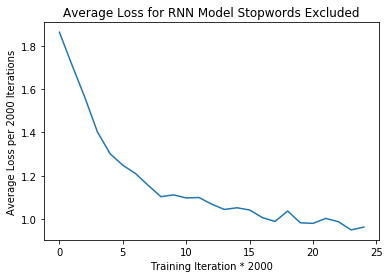

In [14]:
plt.plot(losses)
plt.xlabel('Training Iteration * {}'.format(int(n_iters / avg_loss_intervals)))
plt.ylabel('Average Loss per {} Iterations'.format(int(n_iters / avg_loss_intervals)))
plt.title('Average Loss for RNN Model Stopwords Excluded')
plt.show()

In [15]:
def getAccuracy(dataset):
    total_words = len(dataset.index)
    correct_predictions = 0
    for i in dataset.index:
        word = dataset['Word'][i]
        language = dataset['Language'][i]
        prediction = predict(word)[0][1]
        if prediction == language:
            correct_predictions += 1
    return correct_predictions / total_words

In [16]:
print('training data accuracy: {:.4f}%'.format(getAccuracy(train_data) * 100))
print('testing data accuracy: {:.4f}%'.format(getAccuracy(test_data) * 100))

training data accuracy: 61.5350%
testing data accuracy: 54.6679%


## Stopwords Included

In [17]:
csv_data = parseCSV('language_dataset_with_stopwords.csv')
train_data, test_data = train_test_split(csv_data, test_size=0.2)

training_words = reformatData(train_data)
testing_words = reformatData(test_data)

all_languages = list(training_words.keys())
n_languages = len(all_languages)

print('Number of Words per Language')
csv_data.groupby('Language').size()

Number of Words per Language


Language
English           1000
French            1000
German            1000
Italian           1000
Simlish            111
Spanish           1000
Tolkien Elvish     894
dtype: int64

In [18]:
rnn = RNN(n_letters, n_hidden, n_languages)
losses = train_charRNN(n_iters, learning_rate, avg_loss_intervals)

2000 4% (0m 10s) 1.8440 reclamación / English ✗ (Spanish)
Average loss: 1.8014
4000 8% (0m 19s) 1.8609 direkt / English ✗ (German)
Average loss: 1.5774
6000 12% (0m 27s) 1.7245 solución / English ✗ (Spanish)
Average loss: 1.4833
8000 16% (0m 36s) 1.9190 gutta / Spanish ✗ (Simlish)
Average loss: 1.3869
10000 20% (0m 44s) 0.6830 pesada / Spanish ✓
Average loss: 1.2557
12000 24% (0m 53s) 1.5987 horse / English ✓
Average loss: 1.1762
14000 28% (1m 2s) 2.1891 zerpa / Spanish ✗ (Simlish)
Average loss: 1.1969
16000 32% (1m 10s) 0.3370 sugnorg / Simlish ✓
Average loss: 1.1154
18000 36% (1m 19s) 0.4386 -se-sē̆ / Tolkien Elvish ✓
Average loss: 1.1221
20000 40% (1m 28s) 1.2855 shooflee / French ✗ (Simlish)
Average loss: 1.0722
22000 44% (1m 38s) 0.0896 tekmē / Tolkien Elvish ✓
Average loss: 1.0153
24000 48% (1m 48s) 0.2172 vadish / Simlish ✓
Average loss: 1.0104
26000 52% (1m 58s) 2.2439 shooflee / German ✗ (Simlish)
Average loss: 1.0621
28000 56% (2m 7s) 2.1409 pece / English ✗ (Italian)
Average

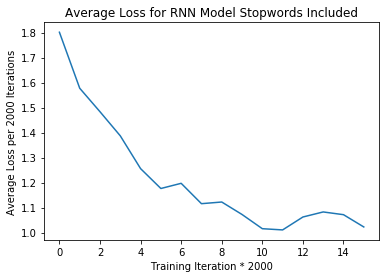

In [19]:
plt.plot(losses)
plt.xlabel('Training Iteration * {}'.format(int(n_iters / avg_loss_intervals)))
plt.ylabel('Average Loss per {} Iterations'.format(int(n_iters / avg_loss_intervals)))
plt.title('Average Loss for RNN Model Stopwords Included')
plt.show()

In [20]:
print('training data accuracy: {:.4f}%'.format(getAccuracy(train_data) * 100))
print('testing data accuracy: {:.4f}%'.format(getAccuracy(test_data) * 100))

training data accuracy: 16.5279%
testing data accuracy: 17.1524%


## Difficult Words

In [21]:
csv_data = parseCSV('difficult_set.csv')
train_data, test_data = train_test_split(csv_data, test_size=0.2)

training_words = reformatData(train_data)
testing_words = reformatData(test_data)

all_languages = list(training_words.keys())
n_languages = len(all_languages)

print('Number of Words per Language')
csv_data.groupby('Language').size()

Number of Words per Language


Language
English           882
French            790
German            862
Italian           811
Simlish           111
Spanish           821
Tolkien Elvish    893
dtype: int64

In [22]:
rnn = RNN(n_letters, n_hidden, n_languages)
losses = train_charRNN(n_iters, learning_rate, avg_loss_intervals)

2000 4% (0m 9s) 1.6129 libbra / Italian ✓
Average loss: 1.8447
4000 8% (0m 19s) 2.2840 shurb / Tolkien Elvish ✗ (Simlish)
Average loss: 1.5639
6000 12% (0m 29s) 1.1876 mik / Simlish ✓
Average loss: 1.4177
8000 16% (0m 39s) 1.3473 element / French ✗ (English)
Average loss: 1.2789
10000 20% (0m 50s) 0.8979 camta- / Tolkien Elvish ✓
Average loss: 1.2276
12000 24% (1m 0s) 2.2113 exercise / Italian ✗ (English)
Average loss: 1.1902
14000 28% (1m 10s) 0.7622 hear / English ✓
Average loss: 1.1982
16000 32% (1m 20s) 1.7805 os / Simlish ✗ (French)
Average loss: 1.0951
18000 36% (1m 28s) 1.4161 sminu / Tolkien Elvish ✓
Average loss: 1.0644
20000 40% (1m 38s) 0.2125 besitzen / German ✓
Average loss: 1.0502
22000 44% (1m 47s) 1.4580 vens unch / English ✗ (Simlish)
Average loss: 1.0226
24000 48% (1m 57s) 1.0851 número / Italian ✗ (Spanish)
Average loss: 0.9895
26000 52% (2m 7s) 0.4923 balaniā / Tolkien Elvish ✓
Average loss: 1.0030
28000 56% (2m 15s) 0.6090 bay / Simlish ✓
Average loss: 0.9849
30000

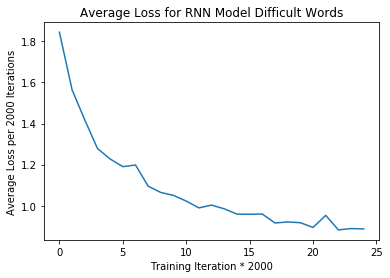

In [23]:
plt.plot(losses)
plt.xlabel('Training Iteration * {}'.format(int(n_iters / avg_loss_intervals)))
plt.ylabel('Average Loss per {} Iterations'.format(int(n_iters / avg_loss_intervals)))
plt.title('Average Loss for RNN Model Difficult Words')
plt.show()

In [24]:
print('training data accuracy: {:.4f}%'.format(getAccuracy(train_data) * 100))
print('testing data accuracy: {:.4f}%'.format(getAccuracy(test_data) * 100))

training data accuracy: 63.8540%
testing data accuracy: 58.4139%


## Only Words Greater than Two Characters Long Included

In [25]:
csv_data = parseCSV('language_dataset_with_stopwords.csv')
filtered_data = csv_data[csv_data['Word'].apply(lambda x: len(x) > 2)]
train_data, test_data = train_test_split(filtered_data, test_size=0.2)

training_words = reformatData(train_data)
testing_words = reformatData(test_data)

all_languages = list(training_words.keys())
n_languages = len(all_languages)

print('Number of Words per Language')
filtered_data.groupby('Language').size()

Number of Words per Language


Language
English           973
French            970
German            984
Italian           968
Simlish           100
Spanish           970
Tolkien Elvish    848
dtype: int64

In [26]:
rnn = RNN(n_letters, n_hidden, n_languages)
losses = train_charRNN(n_iters, learning_rate, avg_loss_intervals)

2000 4% (0m 9s) 1.7043 amar / Tolkien Elvish ✗ (Spanish)
Average loss: 1.7894
4000 8% (0m 18s) 1.7180 thara-pata / Italian ✗ (Tolkien Elvish)
Average loss: 1.5761
6000 12% (0m 28s) 0.2750 Tal / German ✓
Average loss: 1.3857
8000 16% (0m 36s) 0.9703 -ita / Tolkien Elvish ✓
Average loss: 1.2894
10000 20% (0m 46s) 0.9991 taman- / Tolkien Elvish ✓
Average loss: 1.2059
12000 24% (0m 55s) 2.8477 Runde / Tolkien Elvish ✗ (German)
Average loss: 1.1648
14000 28% (1m 5s) 2.5977 soldi / Tolkien Elvish ✗ (Italian)
Average loss: 1.1380
16000 32% (1m 14s) 0.5525 sail / English ✓
Average loss: 1.0819
18000 36% (1m 24s) 0.5627 mbar- / Tolkien Elvish ✓
Average loss: 1.0882
20000 40% (1m 33s) 1.4078 alcuni / Italian ✓
Average loss: 0.9999
22000 44% (1m 43s) 1.7485 et-pel / English ✗ (Tolkien Elvish)
Average loss: 0.9995
24000 48% (1m 53s) 1.1161 stampa / Italian ✓
Average loss: 0.9634
26000 52% (2m 2s) 0.3127 mercado / Spanish ✓
Average loss: 0.9715
28000 56% (2m 12s) 0.3017 ndīlī / Tolkien Elvish ✓
Ave

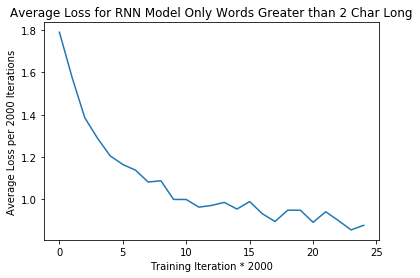

In [27]:
plt.plot(losses)
plt.xlabel('Training Iteration * {}'.format(int(n_iters / avg_loss_intervals)))
plt.ylabel('Average Loss per {} Iterations'.format(int(n_iters / avg_loss_intervals)))
plt.title('Average Loss for RNN Model Only Words Greater than 2 Char Long')
plt.show()

In [28]:
print('training data accuracy: {:.4f}%'.format(getAccuracy(train_data) * 100))
print('testing data accuracy: {:.4f}%'.format(getAccuracy(test_data) * 100))

training data accuracy: 60.8602%
testing data accuracy: 55.6320%


## Only Words Greater than Three Characters Long Included

In [29]:
csv_data = parseCSV('language_dataset_with_stopwords.csv')
filtered_data = csv_data[csv_data['Word'].apply(lambda x: len(x) > 3)]
train_data, test_data = train_test_split(filtered_data, test_size=0.2)

training_words = reformatData(train_data)
testing_words = reformatData(test_data)

all_languages = list(training_words.keys())
n_languages = len(all_languages)

print('Number of Words per Language')
filtered_data.groupby('Language').size()

Number of Words per Language


Language
English           848
French            882
German            905
Italian           925
Simlish            83
Spanish           918
Tolkien Elvish    773
dtype: int64

In [ ]:
rnn = RNN(n_letters, n_hidden, n_languages)
losses = train_charRNN(n_iters, learning_rate, avg_loss_intervals)

2000 4% (0m 9s) 1.7839 care / French ✗ (English)
Average loss: 1.7782


In [ ]:
plt.plot(losses)
plt.xlabel('Training Iteration * {}'.format(int(n_iters / avg_loss_intervals)))
plt.ylabel('Average Loss per {} Iterations'.format(int(n_iters / avg_loss_intervals)))
plt.title('Average Loss for RNN Model Only Words Greater than 3 Char Long')
plt.show()

In [ ]:
print('training data accuracy: {:.4f}%'.format(getAccuracy(train_data) * 100))
print('testing data accuracy: {:.4f}%'.format(getAccuracy(test_data) * 100))